In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.stats import binned_statistic_2d

from numpy.polynomial import polynomial as P
from scipy.stats import binned_statistic

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
def create_dic(dic):
    
    tt = np.array(dic['tmin'])
    mask = np.where(tt<=-50)
    
    pp = np.array(dic['pmax'])[mask]
    sh = np.array(dic['shear'])[mask] #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])[mask]
    umax = np.array(dic['u925'])[mask]
    qq = np.array(dic['q925'])[mask]
    qup = np.array(dic['q650'])[mask]
    tup = np.array(dic['t650'])[mask]
    tlow = np.array(dic['t925'])[mask]
    tt = np.array(dic['tmin'])[mask]
    ttm = np.array(dic['tmean'])[mask]
    month = np.array(dic['month'])[mask]
    hour = np.array(dic['hour'])[mask]
    year = np.array(dic['year'])[mask]
    area = np.array(dic['area'])[mask]
    lat = np.array(dic['clat'])[mask]
    lon = np.array(dic['clon'])[mask]
    tcwv = np.array(dic['tcwv'])[mask]
  #  tgrad = np.array(dic['tgrad'])[mask]
  #  tbox = np.array(dic['tbox'])[mask]
    rh = np.array(dic['rh925'])[mask]
    pall = np.array(dic['p'])[mask]
    
    
    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup, 'K')
    
#     thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
#     #thetae_up = u_met.theta_e(650, tup-273.15, qup)


#     thetae_down_man = u_met.theta_e(925, tlow-273.15, qq)

#     p = units.Quantity(925, 'hPa')
#     t = units.Quantity(tlow, 'K')
#     q = units.Quantity(qq, 'kg/kg')
#     thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
#     dew = calc.dewpoint_from_specific_humidity(q, t, p)
#     thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))-273.15
   
#     thetae = thetae_down - thetaes_up
#     thetaes = thetaes_down - thetaes_up
    
#     qdef = u_met.qdeficit(qq, tup, 650)
    
    #ipdb.set_trace()
    
#     if tgrad.ndim == 2:
#         tgrad = tlow
#     if tbox.ndim == 2:
#         tbox = tlow   ############## this is just to deal with tbox error

    obs_pcp = {
        'prcp' : pp+3,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        #'t650' : tup-273.15,
        'shear' : sh*-1,
        'month' : month,    
        'hour' : hour,
        'year' : year,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'rh' : rh,
        #'tmean' : ttm,
        #'theta' : theta,
#         'theta_e' : thetae,
#         'theta_es' : thetaes,
        #'thup' : thetae_up,
        #'thdown' : thetae_down,
        'tcw' : tcwv,
       # 'tgrad' : tgrad.squeeze(),
      #  'tbox' : tbox.squeeze(),
        'lat' : lat,
        'lon' : lon,
        'pall' : pall
    } 
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [4]:
def create_dic_model(dic):
    
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shearmin']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['umin_mid'])
    umax = np.array(dic['umax_srfc'])
    qq = np.array(dic['qmax']) #+ 0.5
    tup = np.array(dic['tmidmax'])
    tcwv = np.array(dic['tcwv'])
   # tgrad = np.array(dic['tgrad'])
  #  tbox = np.array(dic['tdiff'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    tsrfc = np.array(dic['tsrfcmax']) #+ 3
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    pall = np.array(dic['p'])

    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup+273.15, 'K')
    
#     thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))
    
#     thetaes_up = []
#     ipdb.set_trace()
#     for tl in t:
#         try:
#             thetaa = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
#             thetaes_up.append(thetaa)
#             ipdb.set_trace()
#         except:
#             thetaes_up.append(np.nan)

#     thetaes_up = np.array(thetaes_up)

#     p = units.Quantity(925, 'hPa')
#     t = units.Quantity(tsrfc+273.15, 'K')
#     q = units.Quantity(qq/1000, 'kg/kg')
#     thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))
#     dew = calc.dewpoint_from_specific_humidity(q, t, p)
#     thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))
    
#     thetaes_down = []

#     for tl in t:
#         try:
#             thetaee = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
            
#             thetaes_down.append(thetaee)    
#         except:
#             thetaes_down.append(np.nan) 

#     thetaes_down = np.array(thetaes_down)  
    
#     thetaes = thetaes_down-thetaes_up  
#     thetae = thetae_down -thetaes_up  
# #     qdef = u_met.qdeficit(qq/1000, tup+273.15, 650)
    
#     try:
#         thetamax = np.array(dic['thetamax'])
#         thetamean = np.array(dic['thetamean'])   
#     except:
#         pass

    obs_pcp = {
        'prcp' : pp+2,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq,
        't925' : tsrfc,
        'tcw' : tcwv,
       # 'tgrad' : tgrad,
      #  'tbox' : tbox,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(4.4**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
#         'theta_es' : thetaes,
        'pall' : pall
    } 

#     try:
#     obs_pcp['theta_e']=thetae #+4
#         #obs_pcp['thetamean']=thetamean
#     except:
#         pass
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [5]:
ttag = 'hourly'
if ttag=='hourly':
    rres = 'means'
else:
    rres = '0.7deg'
cp4_histf = ('modelhist', cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4'+rres+'_'+ttag+'_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_hist_*.p')
cp4_futf = ('modelfut' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4'+rres+'_'+ttag+'_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_fut_*.p')
gpmf = ('obs' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_'+ttag+'_*.p')
dlist = [cp4_histf,cp4_futf,gpmf]

In [6]:
for d in dlist:
    
    #ipdb.set_trace()
    ds = glob.glob(d[1])
    
    
    
    for ids, dss in enumerate(ds):
        data = pkl.load( open (dss, 'rb'))
        #data.update(dat)
        
        if 'model' in d[0]:
            if d[0] == 'modelhist':
                cp4_h = create_dic_model(data)
                if ids > 0:
                    histf = pd.concat([histf, cp4_h])
                else:
                    histf = cp4_h    
            else:
                cp4_f = create_dic_model(data)
                if ids > 0:
                    futf = pd.concat([futf, cp4_f])
                else:
                    futf = cp4_f
        if 'obs' in d[0]:
            if d[0] == 'obsm':
                obs_gpmc_m = create_dic(data)
                if ids > 0:
                    obs_gpmc = pd.concat([obs_gpmc, obs_gpmc_m])
                else:
                    obs_gpmc = obs_gpmc_m
            else:
                obs_gpmf_h = create_dic(data)
                if ids > 0:
                    obs_gpmf = pd.concat([obs_gpmf, obs_gpmf_h])
                else:
                    obs_gpmf = obs_gpmf_h
                    

        del data

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [7]:
print(np.max(obs_gpmf.lat))
print(np.min(obs_gpmf.lat))
print(np.max(obs_gpmf.lon))
print(np.min(obs_gpmf.lon))

17.824957782145926
5.160526954051596
12.107882421128927
-16.97683096799293


In [24]:
obs_gpm = obs_gpm[(obs_gpm['hour']>=14)]

In [8]:
tag = 'Sahel'
domainSA = [-10,12,5,8.5]
domainSS = [-10,15,9,18]  # 8.5, 17.5
domainWA = [-10,12,5,17.5]
domainOuaga = [-4.5,2,11,13.5]  
nb = 23
if ttag == 'hourly':
    region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(9.5,17.8,nb) , np.linspace(3,24,nb), np.linspace(-10,10,nb), np.linspace(29,55,nb)], #TCW np.linspace(25,57,nb) #np.linspace(10,17.5,17) , np.linspace(0,25,17)  # monthly tcwv 30-50
              'Ouaga' : [domainOuaga, 'Ouaga', np.linspace(9.5,17.8,nb) , np.linspace(0,27,nb), np.linspace(-10,10,nb), np.linspace(25,57,nb)],
              'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,nb), np.linspace(3,27,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
              'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,nb), np.linspace(0,25,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
             }
else:
    region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(9.5,17.8,nb) , np.linspace(7,18,nb), np.linspace(-10,10,nb), np.linspace(28,51,nb)], # 28,51 #np.linspace(10,17.5,17) , np.linspace(0,25,17)  # monthly tcwv 30-50
          'Ouaga' : [domainOuaga, 'Ouaga', np.linspace(9.5,17.8,nb) , np.linspace(0,27,nb), np.linspace(-10,10,nb), np.linspace(25,57,nb)],
          'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,nb), np.linspace(3,27,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
          'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,nb), np.linspace(0,25,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
         }


domain = region[tag][0]
tname = region[tag][1]
qbins = region[tag][2]
shearbins = region[tag][3]
thetabins = region[tag][4]
tcwvbins=region[tag][5]
qshearbins = qbins*shearbins

m1 = 8#3
m2 =8#11
obs_gpm = obs_gpmf[(obs_gpmf.lon>=domain[0])&(obs_gpmf.lon<=domain[1])&(obs_gpmf.lat>=domain[2])&(obs_gpmf.lat<=domain[3])& (obs_gpmf.month>=m1) & (obs_gpmf.month<=m2)] #& (obs_gpm.month!=6) & (obs_gpm.month!=9)]
hist = histf[(histf.lon>=domain[0])&(histf.lon<=domain[1])&(histf.lat>=domain[2])&(histf.lat<=domain[3])& (histf.month>=m1) & (histf.month<=m2)]# & (histf.tbox<=10)]
fut = futf[(futf.lon>=domain[0])&(futf.lon<=domain[1])&(futf.lat>=domain[2])&(futf.lat<=domain[3])& (futf.month>=m1) & (futf.month<=m2)]# & (futf.tbox<=10)]


In [9]:
np.sum(np.isnan(obs_gpm['tmin']))

0

In [ ]:
len(obs_gpm)

In [16]:
np.sum(np.isnan(obs_gpm.tmin))

0

In [11]:

def calc_density(v1,v2):

    xy = np.vstack([v1, v2])

    z = gaussian_kde(xy)(xy)

    return z / (z.max() - z.min())


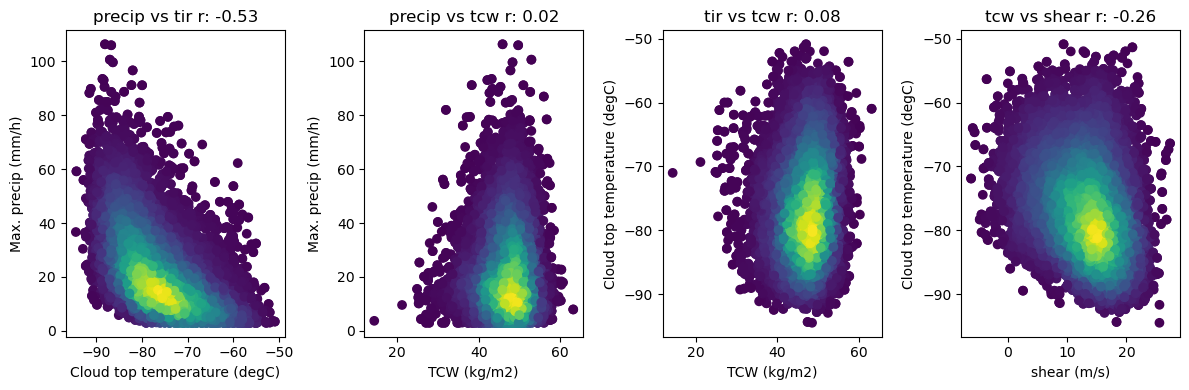

In [12]:

f = plt.figure(figsize=(12,4), dpi=100)
ax = f.add_subplot(141)
cp4s = [obs_gpm.tmin, obs_gpm.prcp] 
r = stats.pearsonr(cp4s[0],cp4s[1])
density = calc_density(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1], c=density)
plt.title('precip vs tir r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('Cloud top temperature (degC)')
plt.ylabel('Max. precip (mm/h)')

ax = f.add_subplot(142)
cp4s = [obs_gpm.tcw, obs_gpm.prcp] 
r = stats.pearsonr(cp4s[0],cp4s[1])
density = calc_density(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1], c=density)
plt.title('precip vs tcw r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('TCW (kg/m2)')
plt.ylabel('Max. precip (mm/h)')

ax = f.add_subplot(143)
# x = obs_gpm.ef[np.isfinite(obs_gpm.ef)]
# y = obs_gpm.prcp[np.isfinite(obs_gpm.ef)]
# cp4s = [x, y]
cp4s = [obs_gpm.tcw, obs_gpm.tmin]
r = stats.pearsonr(cp4s[0],cp4s[1])
density = calc_density(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1], c=density)
plt.title('tir vs tcw r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('TCW (kg/m2)')
plt.ylabel('Cloud top temperature (degC)')
plt.tight_layout()
ax = f.add_subplot(144)
cp4s = [obs_gpm.shear, obs_gpm.tmin]
r = stats.pearsonr(cp4s[0],cp4s[1])
density = calc_density(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1], c=density)
plt.title('tcw vs shear r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('shear (m/s)')
plt.ylabel('Cloud top temperature (degC)')
plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/DYAMOND/dyamondWINTER_UM-5km_WA_scatter_shear.jpg')

In [23]:
p_tcw, bin_edges, binnumber = binned_statistic(obs_gpm.tcw, obs_gpm.prcp, statistic='mean', bins=np.linspace(20,55,20))
tcbins = bin_edges[0:-1] + (bin_edges[1::]-bin_edges[0:-1])/2
pslope, pintercept, pr_value, pp_value, pstd_err = stats.linregress(tcbins[np.isfinite(tcbins)&np.isfinite(p_tcw)], p_tcw[np.isfinite(tcbins)&np.isfinite(p_tcw)])
tir_tcw, bin_edges, binnumber = binned_statistic(obs_gpm.tcw, obs_gpm.tmin, statistic='mean', bins=np.linspace(20,55,20))
tibins = bin_edges[0:-1] + (bin_edges[1::]-bin_edges[0:-1])/2
tslope, tintercept, tr_value, tp_value, tstd_err = stats.linregress(tibins, tir_tcw)

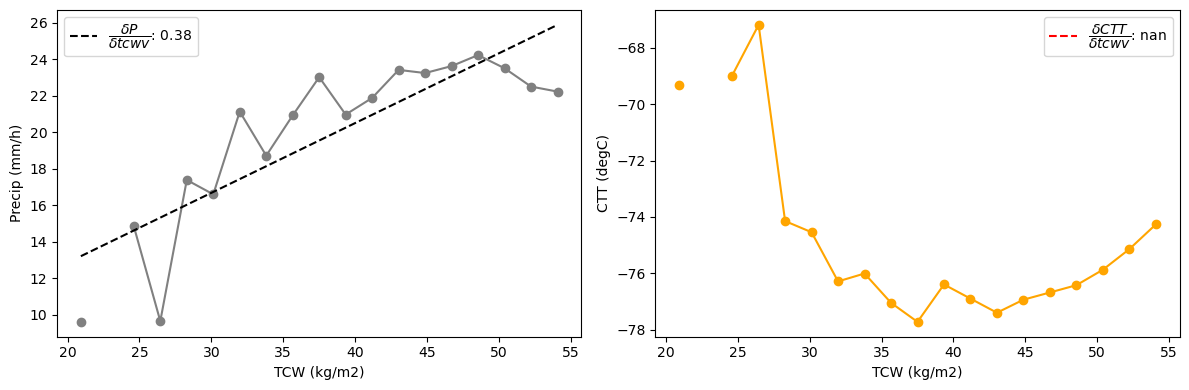

In [24]:
f = plt.figure(figsize=(12,4), dpi=100)
ax = f.add_subplot(121)
plt.plot(tcbins, p_tcw, color='grey', marker='o')
plt.plot(tcbins, pintercept+np.array(tcbins)*pslope, linestyle='dashed', color='k', label=r'$\dfrac{\delta P}{\delta tcwv}$: ' + str(np.round(pslope,2)))
plt.xlabel('TCW (kg/m2)')
plt.ylabel('Precip (mm/h)')
plt.legend()

ax = f.add_subplot(122)
plt.plot(tibins, tir_tcw, color='orange', marker='o')
plt.plot(tibins, tintercept+np.array(tibins)*tslope, linestyle='dashed', color='r', label=r'$\dfrac{\delta CTT}{\delta tcwv}$: ' + str(np.round(tslope,2)))
plt.xlabel('TCW (kg/m2)')
plt.ylabel('CTT (degC)')
plt.legend()
plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/DYAMOND/dyamond_OBS_WA_averageScaling_TCWbin_unitCorrection_shearTCW.jpg')

In [61]:
p_tcw, bin_edges, binnumber = binned_statistic(obs_gpm.shear, obs_gpm.prcp, statistic='mean', bins=np.linspace(0,17,20))
tcbins = bin_edges[0:-1] + (bin_edges[1::]-bin_edges[0:-1])/2
pslope, pintercept, pr_value, pp_value, pstd_err = stats.linregress(tcbins, p_tcw)
tir_tcw, bin_edges, binnumber = binned_statistic(obs_gpm.shear, obs_gpm.tmin, statistic='mean', bins=np.linspace(0,17,20))
tibins = bin_edges[0:-1] + (bin_edges[1::]-bin_edges[0:-1])/2
tslope, tintercept, tr_value, tp_value, tstd_err = stats.linregress(tibins, tir_tcw)

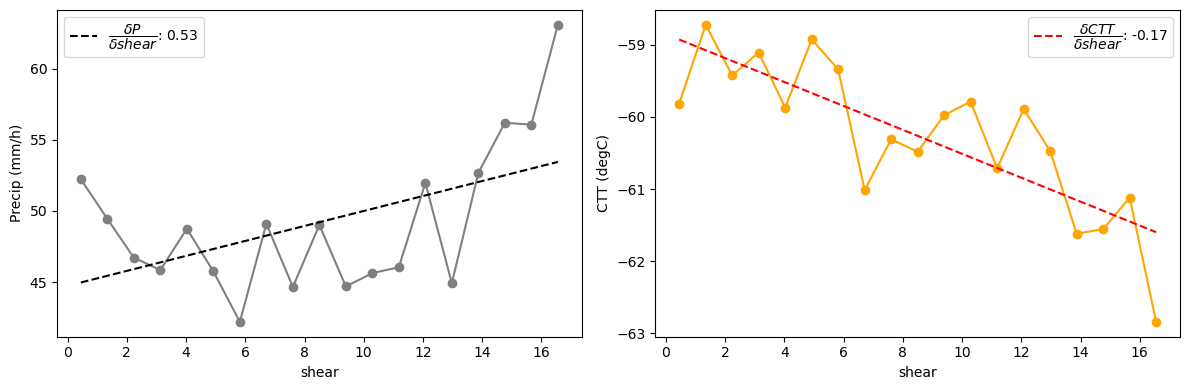

In [62]:
f = plt.figure(figsize=(12,4), dpi=100)
ax = f.add_subplot(121)
plt.plot(tcbins, p_tcw, color='grey', marker='o')
plt.plot(tcbins, pintercept+np.array(tcbins)*pslope, linestyle='dashed', color='k', label=r'$\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pslope,2)))
plt.xlabel('shear')
plt.ylabel('Precip (mm/h)')
plt.legend()

ax = f.add_subplot(122)
plt.plot(tibins, tir_tcw, color='orange', marker='o')
plt.plot(tibins, tintercept+np.array(tibins)*tslope, linestyle='dashed', color='r', label=r'$\dfrac{\delta CTT}{\delta shear}$: ' + str(np.round(tslope,2)))
plt.xlabel('shear')
plt.ylabel('CTT (degC)')
plt.legend()
plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/DYAMOND/dyamond_UM-5km_WA_averageScaling_TCWbin_unitCorrection_shear.jpg')